# Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### [25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

### [25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)
* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding
* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### [25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### [25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import  XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN



In [3]:
!pip3 install missingno
import missingno as msno

In [4]:
!pip3 install catboost

In [5]:
!pip install category_encoders

In [6]:
from category_encoders.cat_boost import CatBoostEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
with open("/content/drive/My Drive/ML/test.csv", 'r') as f:
  print(f.readline())


AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,target



In [9]:
test = pd.read_csv("/content/drive/My Drive/ML/test.csv", na_values="?", skipinitialspace=True)
train = pd.read_csv("/content/drive/My Drive/ML/train.csv", na_values= "?", skipinitialspace=True)

In [10]:
train['target'].unique()

array(['- 50000.', '50000+.'], dtype=object)

I will transform target feature to numeric

1.   '- 50000.' -> 0
2.   '50000+.' -> 1



In [11]:
def to_binary_f(zero_f_name, one_f_name, df, column_name):
  df[column_name].replace(zero_f_name, 0, inplace = True)
  df[column_name].replace(one_f_name, 1, inplace = True)

In [12]:
to_binary_f('- 50000.', '50000+.', train, 'target')
to_binary_f('- 50000.', '50000+.', test, 'target')

In [13]:
#Dictionary to interpret variables' abbreviations
#regexp used to find abbreviations '(.+?)\s([A-Z0-9]*)$' replace '["\2","\1"],' 
feature_trl = {f[0]: f[1] for f in [["AAGE","age"],
                                      ["ACLSWKR","class of worker"],
                                      ["ADTIND","industry code"],
                                      ["ADTOCC","occupation code"],
                                      ["AGI","adjusted gross income"],
                                      ["AHGA","education"],
                                      ["AHRSPAY","wage per hour"],
                                      ["AHSCOL","enrolled in edu inst last wk"],
                                      ["AMARITL","marital status"],
                                      ["AMJIND","major industry code"],
                                      ["AMJOCC","major occupation code"],
                                      ["ARACE","mace"],
                                      ["AREORGN","hispanic Origin"],
                                      ["ASEX","sex"],
                                      ["AUNMEM","member of a labor union"],
                                      ["AUNTYPE","reason for unemployment"],
                                      ["AWKSTAT","full or part time employment stat"],
                                      ["CAPGAIN","capital gains"],
                                      ["CAPLOSS","capital losses"],
                                      ["DIVVAL","divdends from stocks"],
                                      ["FEDTAX","federal income tax liability"],
                                      ["FILESTAT","tax filer status"],
                                      ["GRINREG","region of previous residence"],
                                      ["GRINST","state of previous residence"],
                                      ["HHDFMX","detailed household and family stat"],
                                      ["HHDREL","detailed household summary in household"],
                                      ["MARSUPWT","instance weight"],
                                      ["MIGMTR1","migration code-change in msa"],
                                      ["MIGMTR3","migration code-change in reg"],
                                      ["MIGMTR4","migration code-move within reg"],
                                      ["MIGSAME","live in this house 1 year ago"],
                                      ["MIGSUN","migration prev res in sunbelt"],
                                      ["NOEMP","num persons worked for employer"],
                                      ["PARENT","family members under 18"],
                                      ["PEARNVAL","total person earnings"],
                                      ["PEFNTVTY","country of birth father"],
                                      ["PEMNTVTY","country of birth mother"],
                                      ["PENATVTY","country of birth self"],
                                      ["PRCITSHP","citizenship"],
                                      ["PTOTVAL","total person income"],
                                      ["SEOTR","own business or self employed"],
                                      ["TAXINC","taxable income amount"],
                                      ["VETQVA","fill inc questionnaire for veteran's admin"],
                                      ["VETYN","veterans benefits"],
                                      ["WKSWORK","weeks worked in year"]]}

Our data is imbalanced. However, proportions of missing data in Train and Test are similar. 

<a id=1.1></a>
**1.1 Metric** \\
We have havely imbalanced data. That is why to evaluate the performances of models' I will use F1-score, becasue I want to optimise recall to rarely miss positive class and precision to increase confidence in what model labels as positive class.

**1.2 Validation strategy**\\
For tuning hyperparameters of each midel I will use gread-search with cross-validation on train set. Also I will need to validate a meta-model for that I need to separate validation set in advace.


In [14]:
X, y = train.copy(), train['target']
X_test, y_test = test.copy(), test['target']
X.drop('target', axis=1, inplace=True)
X_test.drop('target', axis=1, inplace=True)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)

In [16]:
print('Positive class (50000+) proportion in TRAIN data:')
round(y_train.value_counts()[1]/len(y_train), 3)

Positive class (50000+) proportion in TRAIN data:


0.062

In [17]:
print('Positive class (50000+) proportion in VALIDATION data:')
round(y_val.value_counts()[1]/len(y_val), 3)

Positive class (50000+) proportion in VALIDATION data:


0.062

In [18]:
print('Positive class (50000+) proportion in TEST data:')
round(y_test.value_counts()[1]/len(y_test),3)

Positive class (50000+) proportion in TEST data:


0.062

**Exploring data**

In [19]:
X_train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR3,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK
194010,8,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,Black,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Grandchild <18 never marr child of subfamily RP,Other relative of householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Mother only present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0
65898,19,Private,33,16,High school graduate,0,Not in universe,Never married,Retail trade,Sales,Black,All other,Male,Not in universe,Other job loser,Unemployed part- time,2176,0,0,Single,Not in universe,Not in universe,Nonfamily householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,20
186025,17,Federal government,50,31,10th grade,0,High school,Never married,Public administration,Other service,White,All other,Male,Not in universe,Re-entrant,Unemployed full-time,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Mother only present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0
96233,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0
179074,33,Private,29,38,Associates degree-occup /vocational,1800,Not in universe,Married-civilian spouse present,Transportation,Transportation and material moving,White,All other,Male,Yes,Not in universe,Full-time schedules,7688,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,Italy,Ireland,United-States,Native- Born in the United States,0,Not in universe,2,52


**1.3 Feature exploration**

Numerical features

In [20]:
num_feat = list(X_train.columns[X_train.dtypes == 'int64'])
print(f'Numerical features are:')
for i in num_feat:
  print(i, '-', feature_trl[i])

Numerical features are:
AAGE - age
ADTIND - industry code
ADTOCC - occupation code
AHRSPAY - wage per hour
CAPGAIN - capital gains
CAPLOSS - capital losses
DIVVAL - divdends from stocks
NOEMP - num persons worked for employer
SEOTR - own business or self employed
VETYN - veterans benefits
WKSWORK - weeks worked in year


In [21]:
X_train[num_feat].isnull().sum()

AAGE       0
ADTIND     0
ADTOCC     0
AHRSPAY    0
CAPGAIN    0
CAPLOSS    0
DIVVAL     0
NOEMP      0
SEOTR      0
VETYN      0
WKSWORK    0
dtype: int64

There are no missing values in numerical columns

Let us examine distrubution of numerical features

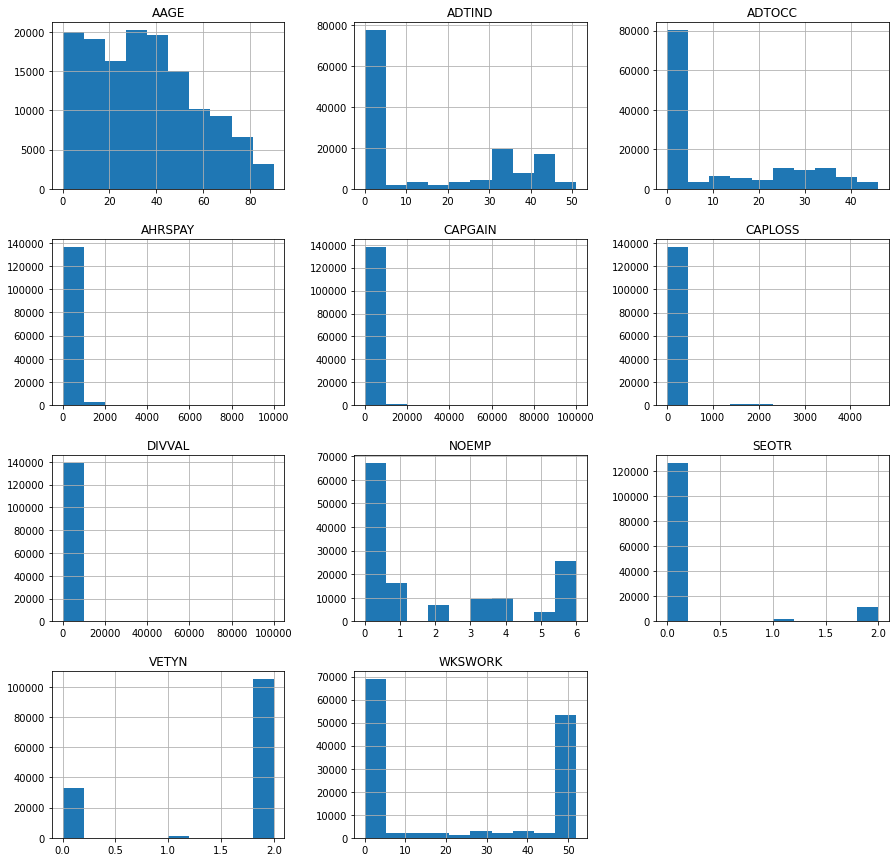

In [22]:
X_train.hist(figsize=(15,15))
plt.show()

In [23]:
scaler = preprocessing.StandardScaler()
scaled_num = pd.DataFrame(scaler.fit_transform(X_train[num_feat]), columns=num_feat)

In [24]:
scaled_num.shape

(139666, 11)

In [25]:
scaled_num_t = scaled_num.join(pd.DataFrame(y_train).reset_index())

In [26]:
scaled_num_t

,AAGE,ADTIND,ADTOCC,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,SEOTR,VETYN,WKSWORK,index,target
0,-1.188445,-0.850063,-0.782308,-0.203305,-0.092675,-0.138526,-0.099350,-0.828090,-0.317014,-1.780396,-0.949931,194010,0
1,-0.694608,0.976166,0.324092,-0.203305,0.368131,-0.138526,-0.099350,1.707484,3.294267,0.569506,-0.131009,65898,0
2,-0.784397,1.916951,1.361341,-0.203305,-0.092675,-0.138526,-0.099350,-0.828090,-0.317014,0.569506,-0.949931,186025,0
3,-0.919079,-0.850063,-0.782308,-0.203305,-0.092675,-0.138526,-0.099350,-0.828090,-0.317014,-1.780396,-0.949931,96233,0
4,-0.066090,0.754805,1.845391,6.332126,1.535394,-0.138526,-0.099350,1.707484,-0.317014,0.569506,1.179266,179074,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139661,-0.200772,1.418889,-0.229108,-0.203305,-0.092675,-0.138526,-0.076502,0.862293,-0.317014,0.569506,1.179266,153653,0
139662,0.113487,0.367423,1.707091,-0.203305,-0.092675,-0.138526,-0.099350,-0.405494,-0.317014,0.569506,1.179266,62042,0
139663,-1.143550,-0.850063,-0.782308,-0.203305,-0.092675,-0.138526,-0.099350,-0.828090,-0.317014,-1.780396,-0.949931,83748,0
139664,-1.188445,-0.850063,-0.782308,-0.203305,-0.092675,-0.138526,-0.099350,-0.828090,-0.317014,-1.780396,-0.949931,128387,0


Correlation of features with each other and with target:

---



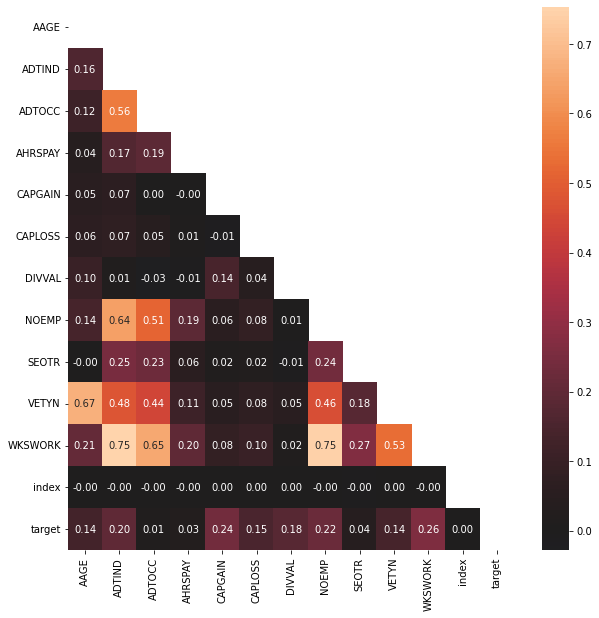

In [27]:
plt.figure(figsize=(10,10))

corr_matrix = scaled_num_t.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=True, center=0);

From the correlation matrix we can guess that 'ADTOCC', 'AHRSPAY', 'SEOTR' are not useful for target prediction.

In [28]:
for ft in ['ADTOCC', 'AHRSPAY', 'SEOTR' ]:
  print(feature_trl[ft])

occupation code
wage per hour
own business or self employed


Candidate columns for dropping are 'ADTOCC', 'AHRSPAY', 'SEOTR' which are 'occupation code', 'wage per hour' and 'own business or self employed' respectivly.

In [29]:
drop_num = ['ADTOCC', 'AHRSPAY', 'SEOTR']

Next I will select features that correlate the most between each other:

In [30]:
strong_corr= set()
corr_cut_off = 0.7
for f_one, f_two in lower.to_dict().items():
  for key, val in f_two.items():
    if val > corr_cut_off:
      strong_corr.add(((f_one, key),val))


In [31]:
strong_corr

{(('ADTIND', 'WKSWORK'), 0.7537173056256038),
 (('NOEMP', 'WKSWORK'), 0.7471944122609123)}

In [32]:
#to undersatnd what values are correlated
for fs, val in strong_corr:
  print(f"{fs[0]}: '{feature_trl[fs[0]]}' - {fs[1]}: '{feature_trl[fs[1]]}'")

NOEMP: 'num persons worked for employer' - WKSWORK: 'weeks worked in year'
ADTIND: 'industry code' - WKSWORK: 'weeks worked in year'


These correlations might be explained with presence of zero values in most of the cases.

**Categorical features**

In [33]:
cat_feat = list(X_train.columns[X_train.dtypes == 'object'])
print('Categorical features are:')
for i in cat_feat:
  print(i, '-', feature_trl[i])

Categorical features are:
ACLSWKR - class of worker
AHGA - education
AHSCOL - enrolled in edu inst last wk
AMARITL - marital status
AMJIND - major industry code
AMJOCC - major occupation code
ARACE - mace
AREORGN - hispanic Origin
ASEX - sex
AUNMEM - member of a labor union
AUNTYPE - reason for unemployment
AWKSTAT - full or part time employment stat
FILESTAT - tax filer status
GRINREG - region of previous residence
GRINST - state of previous residence
HHDFMX - detailed household and family stat
HHDREL - detailed household summary in household
MIGMTR1 - migration code-change in msa
MIGMTR3 - migration code-change in reg
MIGMTR4 - migration code-move within reg
MIGSAME - live in this house 1 year ago
MIGSUN - migration prev res in sunbelt
PARENT - family members under 18
PEFNTVTY - country of birth father
PEMNTVTY - country of birth mother
PENATVTY - country of birth self
PRCITSHP - citizenship
VETQVA - fill inc questionnaire for veteran's admin


In [34]:
len(cat_feat)

28

Let's have a look to 'distribution' of categorical features, without paying attention to exact categories of each features so far.

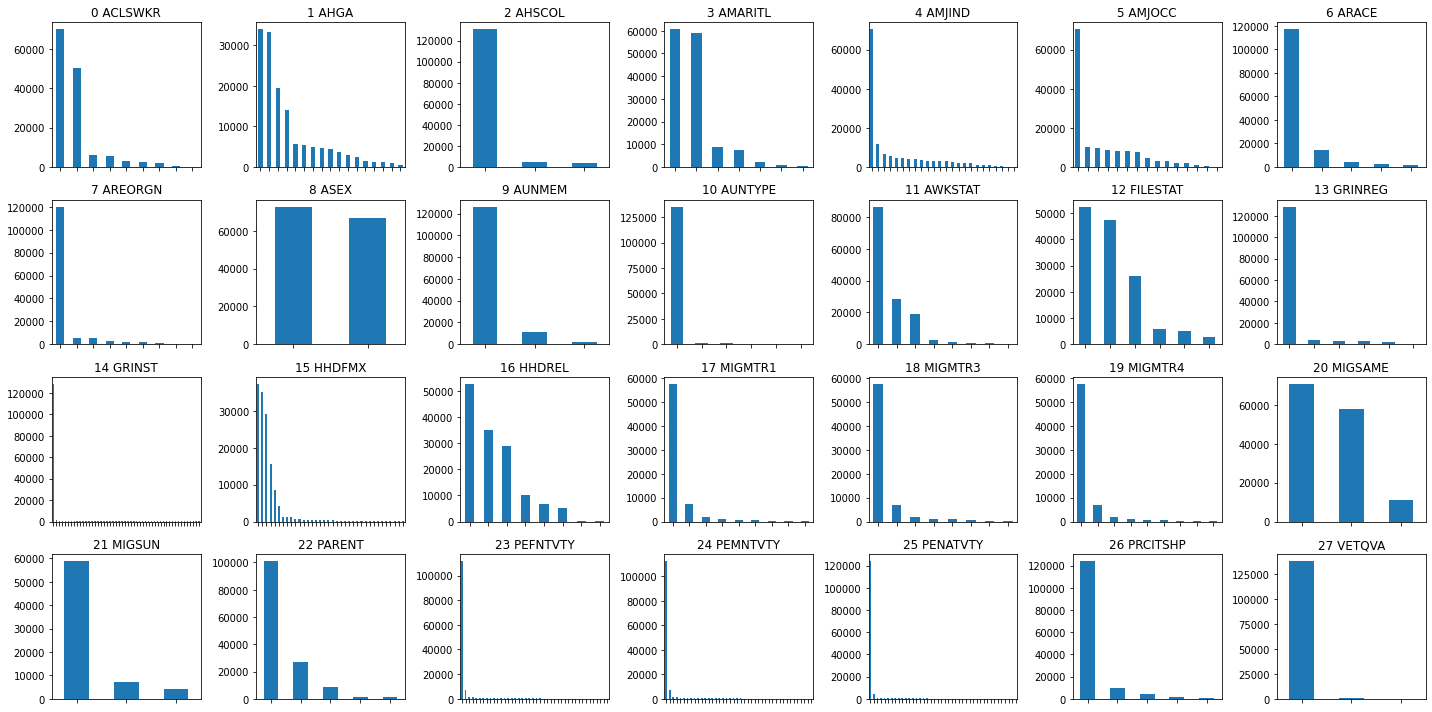

In [35]:
n = len(cat_feat)
fig, axs = plt.subplots(4,7,figsize=(20,10))
col_n = 0
for i, col in enumerate(cat_feat):
  #print(col)
  pos = i%7 + 1
  if i%7 == 0:
    pos =1
    col_n+=1
  X_train[col].value_counts().plot.bar(ax =axs[col_n-1,pos-1])
  axs[col_n-1,pos-1].title.set_text(str(i)+' '+col)
  axs[col_n-1,pos-1].set_xticklabels('')
plt.tight_layout()

Some features has one prevailing category so it is possible to drop them. Such features are: 

In [36]:
pos_to_drop = [2,4,5,6,7,10,13,14,17,18,19,21,23,24,25,26,27]
cat_feat = np.array(cat_feat)
drop_cand = cat_feat[pos_to_drop]
print('Candidates for dropping:')
for ft in drop_cand:
  print(f'{ft} - {feature_trl[ft]}')

Candidates for dropping:
AHSCOL - enrolled in edu inst last wk
AMJIND - major industry code
AMJOCC - major occupation code
ARACE - mace
AREORGN - hispanic Origin
AUNTYPE - reason for unemployment
GRINREG - region of previous residence
GRINST - state of previous residence
MIGMTR1 - migration code-change in msa
MIGMTR3 - migration code-change in reg
MIGMTR4 - migration code-move within reg
MIGSUN - migration prev res in sunbelt
PEFNTVTY - country of birth father
PEMNTVTY - country of birth mother
PENATVTY - country of birth self
PRCITSHP - citizenship
VETQVA - fill inc questionnaire for veteran's admin


2.1 Let us examine missing values

Text(0.5, 1.0, 'Missing data in columns')

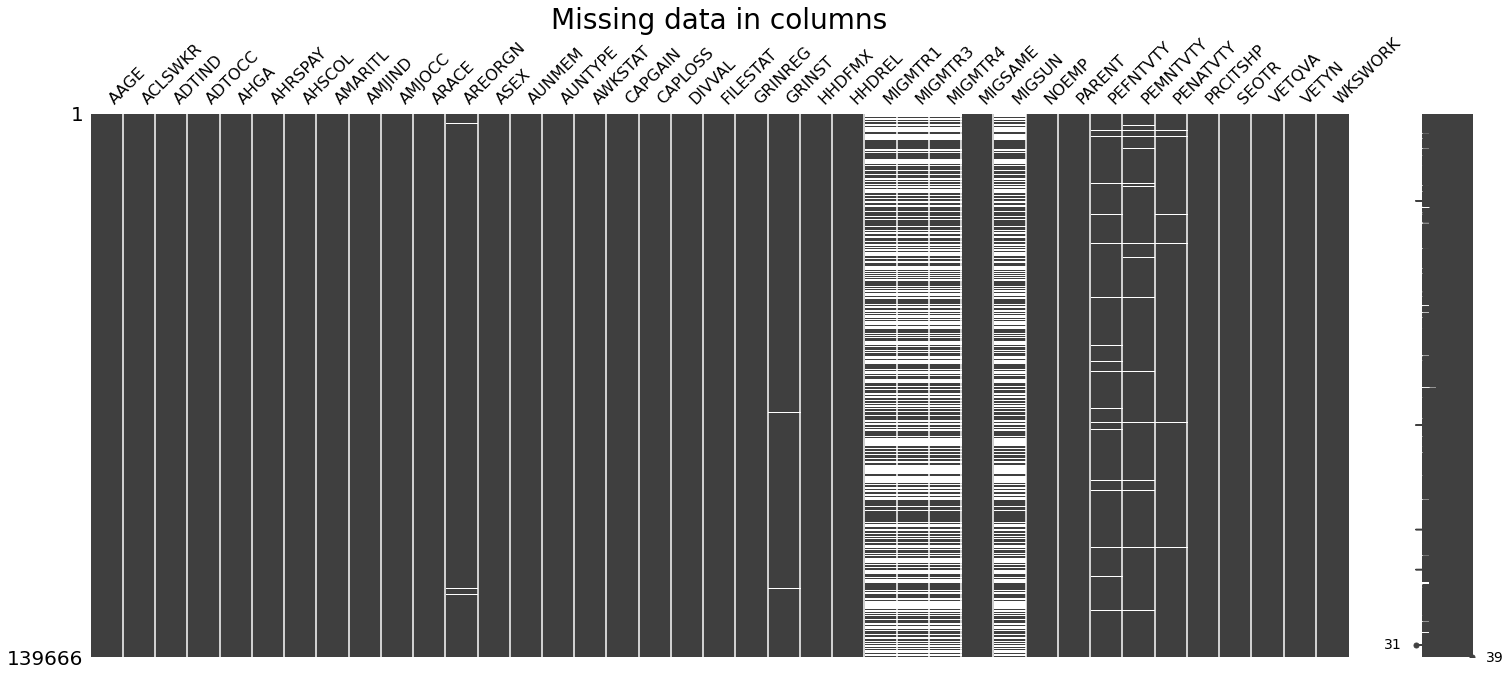

In [37]:
msno.matrix(X_train)
plt.title('Missing data in columns', fontsize = 28)

In [38]:
print('Proportion of missing values in columns')
mask = X_train.isnull().sum()/len(train)
mask[mask!=0]

Proportion of missing values in columns


AREORGN     0.002997
GRINST      0.002561
MIGMTR1     0.349604
MIGMTR3     0.349604
MIGMTR4     0.349604
MIGSUN      0.349604
PEFNTVTY    0.023456
PEMNTVTY    0.021556
PENATVTY    0.011989
dtype: float64

In [39]:
print('The following columns has 30% of data mising')
mask[mask>0.3]

The following columns has 30% of data mising


MIGMTR1    0.349604
MIGMTR3    0.349604
MIGMTR4    0.349604
MIGSUN     0.349604
dtype: float64

Since some columns have low variance and have 30% of the data missing, we will drop them.

In [40]:
sure_drop = list(set(mask[mask>0.3].keys()) & set(drop_cand))

In [41]:
sure_drop

['MIGMTR4', 'MIGMTR1', 'MIGSUN', 'MIGMTR3']

In [42]:
print('Features we need to consider before dropping:')
to_consider = list(set(drop_cand) - set(sure_drop))
print(to_consider)

Features we need to consider before dropping:
['PENATVTY', 'AHSCOL', 'AMJOCC', 'AREORGN', 'AMJIND', 'PEFNTVTY', 'PEMNTVTY', 'AUNTYPE', 'VETQVA', 'ARACE', 'GRINREG', 'PRCITSHP', 'GRINST']


In [43]:
def keep_or_not(col_name):
  #global keep
  train[col_name].value_counts().plot.bar()
  catboost = CatBoostEncoder()
  cb = catboost.fit_transform(train[col_name], train.target, handle_missing='return_nan')
  cr = cb.join(train.target).corr()
  print(f'Correaltion of CatBoost encoded feature and target \n {cr}')
  plt.show()
  return True if cr.iloc[0][1]>0.1 else False


Correaltion of CatBoost encoded feature and target 
           PENATVTY    target
PENATVTY  1.000000  0.051133
target    0.051133  1.000000


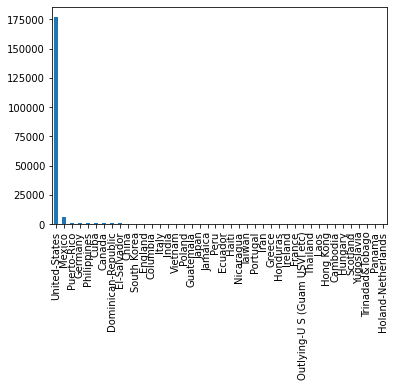

Correaltion of CatBoost encoded feature and target 
           AHSCOL    target
AHSCOL  1.000000  0.063517
target  0.063517  1.000000


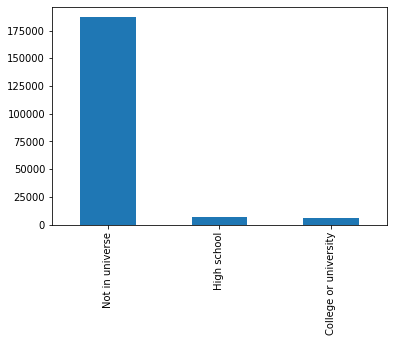

Correaltion of CatBoost encoded feature and target 
           AMJOCC    target
AMJOCC  1.000000  0.365028
target  0.365028  1.000000


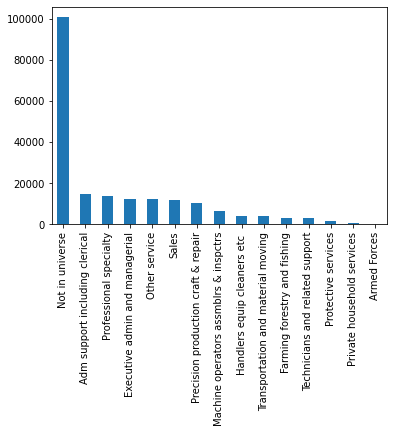

Correaltion of CatBoost encoded feature and target 
           AREORGN    target
AREORGN  1.000000  0.066805
target   0.066805  1.000000


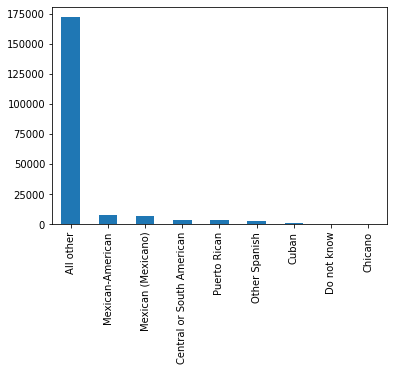

Correaltion of CatBoost encoded feature and target 
           AMJIND    target
AMJIND  1.000000  0.274712
target  0.274712  1.000000


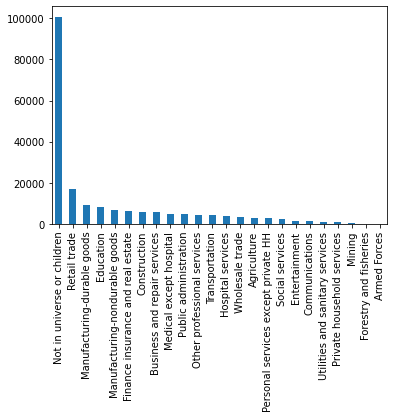

Correaltion of CatBoost encoded feature and target 
           PEFNTVTY    target
PEFNTVTY  1.000000  0.063384
target    0.063384  1.000000


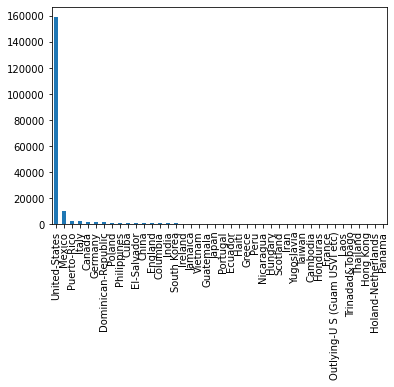

Correaltion of CatBoost encoded feature and target 
           PEMNTVTY    target
PEMNTVTY  1.000000  0.062147
target    0.062147  1.000000


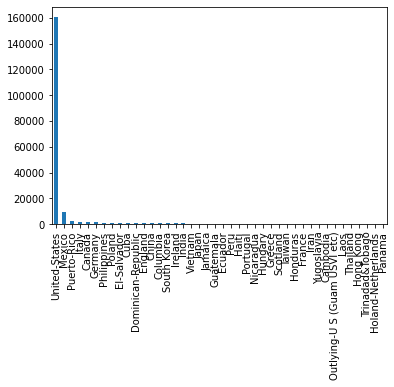

Correaltion of CatBoost encoded feature and target 
           AUNTYPE    target
AUNTYPE  1.000000  0.025475
target   0.025475  1.000000


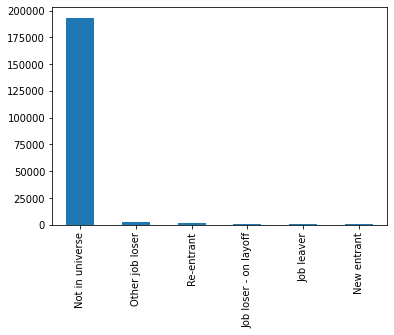

Correaltion of CatBoost encoded feature and target 
           VETQVA    target
VETQVA  1.000000  0.024438
target  0.024438  1.000000


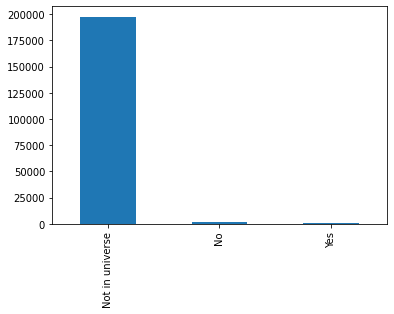

Correaltion of CatBoost encoded feature and target 
            ARACE    target
ARACE   1.000000  0.057207
target  0.057207  1.000000


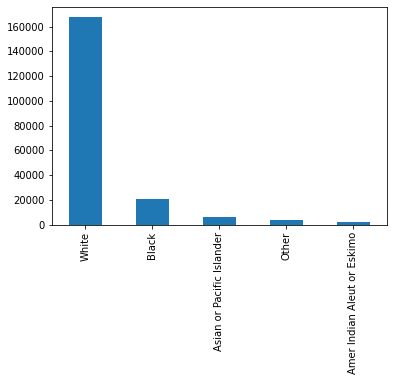

Correaltion of CatBoost encoded feature and target 
           GRINREG    target
GRINREG  1.000000  0.027202
target   0.027202  1.000000


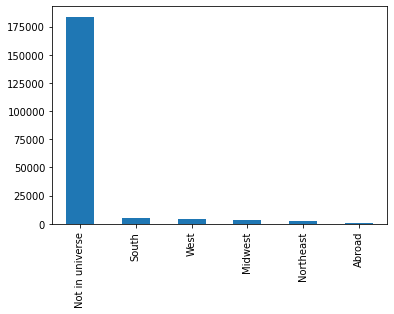

Correaltion of CatBoost encoded feature and target 
           PRCITSHP    target
PRCITSHP  1.000000  0.038487
target    0.038487  1.000000


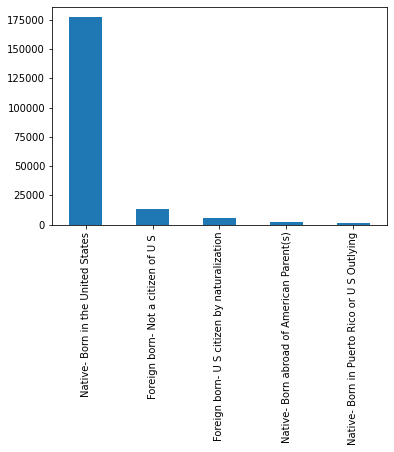

Correaltion of CatBoost encoded feature and target 
          GRINST   target
GRINST  1.00000  0.02423
target  0.02423  1.00000


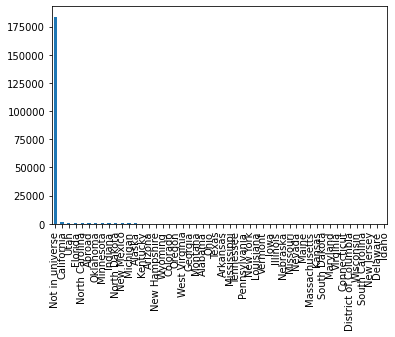

In [44]:
keep = []
for i in to_consider:
  res = keep_or_not(i)
  keep.append(res)

I will keep the following features from questioned features

In [45]:
np.array(to_consider)[keep]

array(['AMJOCC', 'AMJIND'], dtype='<U8')

In [46]:
drop_arr = np.array(to_consider)[np.array(keep) == False]

In [47]:
drop_arr

array(['PENATVTY', 'AHSCOL', 'AREORGN', 'PEFNTVTY', 'PEMNTVTY', 'AUNTYPE',
       'VETQVA', 'ARACE', 'GRINREG', 'PRCITSHP', 'GRINST'], dtype='<U8')

In [48]:
sure_drop = list(set(sure_drop).union(set(drop_arr)))

Finally, we will drop the following features

In [49]:
sure_drop

['PENATVTY',
 'MIGSUN',
 'AHSCOL',
 'AREORGN',
 'PEFNTVTY',
 'PEMNTVTY',
 'AUNTYPE',
 'GRINREG',
 'VETQVA',
 'ARACE',
 'MIGMTR4',
 'MIGMTR1',
 'PRCITSHP',
 'MIGMTR3',
 'GRINST']

In [50]:
X_train.drop(sure_drop, axis=1, inplace=True)
X_val.drop(sure_drop, axis=1, inplace=True)
X_test.drop(sure_drop, axis=1, inplace=True)

In [51]:
X_train.shape

(139666, 24)

I will biniraze gender feature

In [52]:
#to_binary_f(zero_f_name, one_f_name, df, 'column_name')
to_binary_f('Female', 'Male', X_train, 'ASEX')
to_binary_f('Female', 'Male', X_val, 'ASEX')
to_binary_f('Female', 'Male', X_test, 'ASEX')

In [53]:
X_train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AMARITL,AMJIND,AMJOCC,ASEX,AUNMEM,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,HHDFMX,HHDREL,MIGSAME,NOEMP,PARENT,SEOTR,VETYN,WKSWORK
194010,8,Not in universe,0,0,Children,0,Never married,Not in universe or children,Not in universe,0,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Grandchild <18 never marr child of subfamily RP,Other relative of householder,Not in universe under 1 year old,0,Mother only present,0,0,0
65898,19,Private,33,16,High school graduate,0,Never married,Retail trade,Sales,1,Not in universe,Unemployed part- time,2176,0,0,Single,Nonfamily householder,Householder,Not in universe under 1 year old,6,Not in universe,2,2,20
186025,17,Federal government,50,31,10th grade,0,Never married,Public administration,Other service,1,Not in universe,Unemployed full-time,0,0,0,Nonfiler,Child <18 never marr not in subfamily,Child under 18 never married,Not in universe under 1 year old,0,Mother only present,0,2,0
96233,14,Not in universe,0,0,Children,0,Never married,Not in universe or children,Not in universe,1,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Child <18 never marr not in subfamily,Child under 18 never married,Yes,0,Both parents present,0,0,0
179074,33,Private,29,38,Associates degree-occup /vocational,1800,Married-civilian spouse present,Transportation,Transportation and material moving,1,Yes,Full-time schedules,7688,0,0,Joint both under 65,Householder,Householder,Not in universe under 1 year old,6,Not in universe,0,2,52


As an unintended consequence of features dropping out dataset does not contain missing values. But just in case there will be missing values I will fill them with most popular values.

In [54]:
X_train.isnull().sum()

AAGE        0
ACLSWKR     0
ADTIND      0
ADTOCC      0
AHGA        0
AHRSPAY     0
AMARITL     0
AMJIND      0
AMJOCC      0
ASEX        0
AUNMEM      0
AWKSTAT     0
CAPGAIN     0
CAPLOSS     0
DIVVAL      0
FILESTAT    0
HHDFMX      0
HHDREL      0
MIGSAME     0
NOEMP       0
PARENT      0
SEOTR       0
VETYN       0
WKSWORK     0
dtype: int64

In [55]:
X_train.fillna(X_train.median().iloc[0], inplace=True)
X_val.fillna(X_train.median().iloc[0], inplace=True)
X_test.fillna(X_test.median().iloc[0], inplace=True)

**2.2 Encodeing categorical features**
I will use target encoding to encode categorical features, more specifically CatBoost Encoder. Because I want categorical features to be encoded with continious values and minimise target leakage.

In [56]:
X_train.columns[X_train.dtypes == 'object']

Index(['ACLSWKR', 'AHGA', 'AMARITL', 'AMJIND', 'AMJOCC', 'AUNMEM', 'AWKSTAT',
       'FILESTAT', 'HHDFMX', 'HHDREL', 'MIGSAME', 'PARENT'],
      dtype='object')

In [57]:
cb_cat = CatBoostEncoder()
for col in X_train.columns[X_train.dtypes == 'object']:
  cb_cat.fit(X_train[col], y_train)
  X_train[col] = cb_cat.transform(X_train[col])
  X_test[col] = cb_cat.transform(X_test[col])
  X_val[col] = cb_cat.transform(X_val[col])

In [58]:
X_train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AMARITL,AMJIND,AMJOCC,ASEX,AUNMEM,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,HHDFMX,HHDREL,MIGSAME,NOEMP,PARENT,SEOTR,VETYN,WKSWORK
194010,8,0.008732,0,0,0.000002,0,0.013081,0.008707,0.008707,0,0.056279,0.047459,0,0,0,0.000363,0.000048,0.009224,0.064720,0,0.000007,0,0,0
65898,19,0.101437,33,16,0.039038,0,0.013081,0.046014,0.127739,1,0.056279,0.020514,2176,0,0,0.061543,0.081926,0.128001,0.064720,6,0.085824,2,2,20
186025,17,0.202603,50,31,0.008509,0,0.013081,0.183087,0.009458,1,0.056279,0.037739,0,0,0,0.000363,0.000059,0.000058,0.064720,0,0.000007,0,2,0
96233,14,0.008732,0,0,0.000002,0,0.013081,0.008707,0.008707,1,0.056279,0.047459,0,0,0,0.000363,0.000059,0.000058,0.063364,0,0.000076,0,0,0
179074,33,0.101437,29,38,0.074310,1800,0.114085,0.116878,0.065232,1,0.133176,0.132194,7688,0,0,0.131698,0.147194,0.128001,0.064720,6,0.085824,0,2,52


**1.3 Feature selection with PCA**

In [59]:
scaler = preprocessing.StandardScaler()
scaled_X_tr = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
scaled_X_ts = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
scaled_X_val = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)

In [60]:
scaled_X_tr.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AMARITL,AMJIND,AMJOCC,ASEX,AUNMEM,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,HHDFMX,HHDREL,MIGSAME,NOEMP,PARENT,SEOTR,VETYN,WKSWORK
0,-1.188445,-0.839271,-0.850063,-0.782308,-0.654890,-0.203305,-1.027926,-0.791526,-0.598775,-0.959038,-0.322127,-0.375740,-0.092675,-0.138526,-0.09935,-1.110502,-1.069233,-0.961898,0.380007,-0.828090,-1.616439,-0.317014,-1.780396,-0.949931
1,-0.694608,0.619931,0.976166,0.324092,-0.242872,-0.203305,-1.027926,-0.237882,0.737342,1.042711,-0.322127,-1.069378,0.368131,-0.138526,-0.09935,-0.009226,0.342397,1.200615,0.380007,1.707484,0.619154,3.294267,0.569506,-0.131009
2,-0.784397,2.212310,1.916951,1.361341,-0.565103,-0.203305,-1.027926,1.796308,-0.590342,1.042711,-0.322127,-0.625947,-0.092675,-0.138526,-0.09935,-1.110502,-1.069046,-1.128781,0.380007,-0.828090,-1.616439,-0.317014,0.569506,-0.949931
3,-0.919079,-0.839271,-0.850063,-0.782308,-0.654890,-0.203305,-1.027926,-0.791526,-0.598775,1.042711,-0.322127,-0.375740,-0.092675,-0.138526,-0.09935,-1.110502,-1.069046,-1.128781,0.186601,-0.828090,-1.614649,-0.317014,-1.780396,-0.949931
4,-0.066090,0.619931,0.754805,1.845391,0.129413,6.332126,1.092047,0.813746,0.035703,1.042711,3.966819,1.805559,1.535394,-0.138526,-0.09935,1.253625,1.467655,1.200615,0.380007,1.707484,0.619154,-0.317014,0.569506,1.179266


In [61]:
pca = PCA(random_state=42)

In [62]:
pca.fit(scaled_X_tr)

PCA(random_state=42)

In [63]:
scaled_X_tr.shape

(139666, 24)

In [64]:
pca_data_tr = pca.transform(scaled_X_tr)
pca_data_val = pca.transform(scaled_X_val)
pca_data_ts = pca.transform(scaled_X_ts)

In [65]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=2)

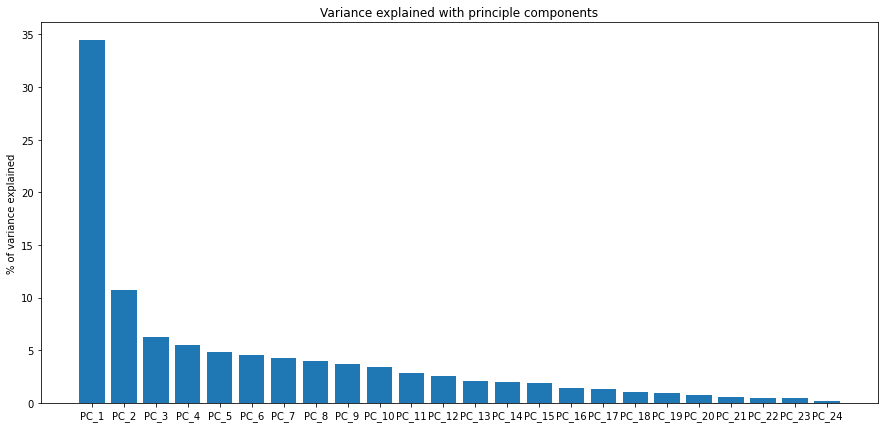

In [66]:
plt.figure(figsize=(15,7))
plt.bar(x=range(1,len(per_var)+1), height= per_var, tick_label = ["PC_"+str(i) for i in range(1, len(per_var)+1)])
plt.ylabel('% of variance explained')
plt.title('Variance explained with principle components')
plt.show()

In [67]:
df_pca_tr = pd.DataFrame(pca_data_tr, columns=["PC_"+str(i) for i in range(1, len(per_var)+1)])
df_pca_ts = pd.DataFrame(pca_data_ts, columns=["PC_"+str(i) for i in range(1, len(per_var)+1)])
df_pca_val = pd.DataFrame(pca_data_val, columns=["PC_"+str(i) for i in range(1, len(per_var)+1)])

In [68]:
df_label_pca = scaled_X_tr.join(pd.DataFrame(y_train).reset_index())

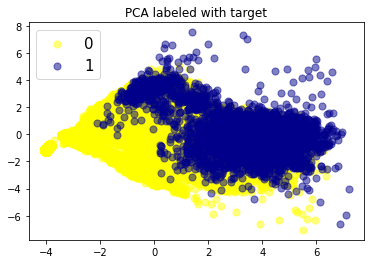

In [69]:
targets = [0, 1]
colors = ['yellow', 'darkblue']
for target, color in zip(targets,colors):
    indicesToKeep = df_label_pca['target'] == target
    plt.scatter(df_pca_tr.loc[indicesToKeep, 'PC_1'],
                df_pca_tr.loc[indicesToKeep, 'PC_2'], c = color, s = 50, alpha=0.5)
plt.legend(targets,prop={'size': 15})
plt.title('PCA labeled with target')
plt.savefig("/content/pca.jpg")

In [70]:
pc1_cont = pd.Series(pca.components_[0], index = scaled_X_tr.columns.tolist()).abs().sort_values(ascending=False)

Below are the top 10 features that explain most of the variance in the train data according to principle component #1.


In [71]:
for i in pc1_cont[:11].keys():
  print(i, '-', feature_trl[i])

WKSWORK - weeks worked in year
FILESTAT - tax filer status
PARENT - family members under 18
ACLSWKR - class of worker
AMJIND - major industry code
ADTIND - industry code
VETYN - veterans benefits
NOEMP - num persons worked for employer
HHDFMX - detailed household and family stat
HHDREL - detailed household summary in household
AMARITL - marital status


In [72]:
pc2_cont = pd.Series(pca.components_[1], index = scaled_X_tr.columns.tolist()).abs().sort_values(ascending=False)
for i in pc2_cont[:11].keys():
  print(i, '-', feature_trl[i])

AAGE - age
HHDREL - detailed household summary in household
HHDFMX - detailed household and family stat
AWKSTAT - full or part time employment stat
AMARITL - marital status
PARENT - family members under 18
ADTIND - industry code
VETYN - veterans benefits
AMJIND - major industry code
NOEMP - num persons worked for employer
ACLSWKR - class of worker


In [73]:
pc1_pc2_top = list(set(pc1_cont.keys()[:11]).intersection(pc2_cont[:11].keys()))
for i in pc1_pc2_top:
  print(i, '-', feature_trl[i])

NOEMP - num persons worked for employer
HHDREL - detailed household summary in household
ACLSWKR - class of worker
VETYN - veterans benefits
PARENT - family members under 18
AMARITL - marital status
ADTIND - industry code
AMJIND - major industry code
HHDFMX - detailed household and family stat


Above features explain the most variance in the data.

To assess feature importance I want to train an ensemble and compare it to the PCA.

In [74]:
from sklearn.ensemble import ExtraTreesClassifier

In [75]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(scaled_X_tr, y_train)

In [76]:
def compute_confusion_matrix(y_test, y_pred):
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=[1, 0]),
        columns=['a(x) = 1', 'a(x) = 0'],
        index=['y = 1', 'y = 0'],
    ).T

In [77]:
y_pred = clf.predict(scaled_X_tr)
print(f'f1-score {f1_score(y_train, y_pred)}')
compute_confusion_matrix(y_train, y_pred)

f1-score 0.9940244822184835


,y = 1,y = 0
a(x) = 1,8567,3
a(x) = 0,100,130996


We see that on Train data ensemble predicts excelent, probably, due to overfitting. Anyway, we did this ensemble training without tuning and just for feature selection purposes. 

In [78]:
ens_imp = list(zip(clf.feature_names_in_,clf.feature_importances_ ))

In [79]:
ens_top = sorted(ens_imp, key=lambda x: x[1], reverse=True)[:11]

In [80]:
conf_feat = set(pc1_cont.keys()[:11]).intersection(set([i[0] for i in ens_top]), pc2_cont[:11].keys())

In [81]:
conf_feat

{'ACLSWKR', 'ADTIND', 'AMJIND', 'NOEMP'}

There are 4 features in common between PCA and the ensemble.

In [82]:
len(set([i[0] for i in ens_top]).union(set(pc2_cont[:11].keys()), set(pc1_cont[:11].keys())))

18

4/18 top features intersect in PCA and features selected by trees ensemble. I will keep for further model trainings union of top 18 features from PCA and the ensemble.

In [83]:
imp_feat = list(set([i[0] for i in ens_top]).union(set(pc2_cont[:11].keys()), set(pc1_cont[:11].keys()))) # we can keep features from PCA and ensemble

In [84]:
imp_feat

['AAGE',
 'AHGA',
 'CAPGAIN',
 'DIVVAL',
 'FILESTAT',
 'ADTOCC',
 'WKSWORK',
 'ACLSWKR',
 'AMARITL',
 'NOEMP',
 'AWKSTAT',
 'HHDREL',
 'AMJOCC',
 'VETYN',
 'PARENT',
 'ADTIND',
 'AMJIND',
 'HHDFMX']

**2.3 Clustering observations**

In [85]:
from sklearn.cluster import KMeans

In [86]:
k_max = 10

inertia = []
for k in range(1, k_max):

    kmeans = KMeans(n_clusters=k).fit(df_pca_tr[['PC_1', 'PC_2']])
    
    inertia.append(np.sqrt(kmeans.inertia_))

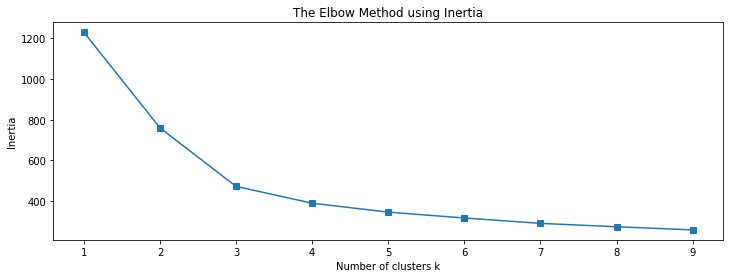

In [87]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

In [88]:
k_means = KMeans(n_clusters=3, random_state=42)
k_means.fit(df_pca_tr[['PC_1', 'PC_2']])
#plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters)

KMeans(n_clusters=3, random_state=42)

In [89]:
clusters_tr = k_means.predict(df_pca_tr[['PC_1', 'PC_2']])
clusters_ts = k_means.predict(df_pca_ts[['PC_1', 'PC_2']])
clusters_val = k_means.predict(df_pca_val[['PC_1', 'PC_2']])


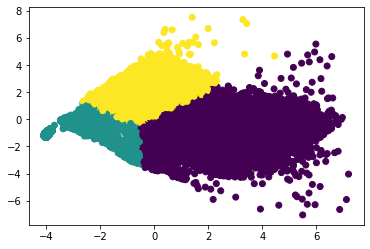

In [90]:
plt.scatter(df_pca_tr['PC_1'], df_pca_tr['PC_2'], c=clusters_tr)

In [91]:
scaled_X_tr = scaled_X_tr.join(pd.DataFrame(clusters_tr, columns=['cluster']))
scaled_X_ts = scaled_X_ts.join(pd.DataFrame(clusters_ts, columns=['cluster']))
scaled_X_val = scaled_X_val.join(pd.DataFrame(clusters_val, columns=['cluster']))

In [92]:
cls = [0, 1, 2]
colors = ['darkblue', 'lightseagreen', 'yellow']
for cl, color in zip(cls,colors):
    indicesToKeep = scaled_X_tr['cluster'] == cl
    plt.scatter(df_pca_tr.loc[indicesToKeep, 'PC_1']
               ,df_pca_tr.loc[indicesToKeep, 'PC_2'], c = color, s = 50)
plt.legend(cls,prop={'size': 15})
plt.title('PCA labeled with K-Means')
plt.savefig("/content/k-means.jpg")
plt.close()

Let's have a look to PCA and K-Means plot side by side.

In [93]:
import ipywidgets as widgets
import IPython.display as display
img1 = open('pca.jpg', 'rb').read()
img2 = open('k-means.jpg', 'rb').read()
wi1 = widgets.Image(value=img1, format='png', width=300, height=400)
wi2 = widgets.Image(value=img2, format='png', width=300, height=400)
## Side by side thanks to HBox widgets
sidebyside = widgets.HBox([wi1, wi2])
## Finally, show.
display.display(sidebyside)


I would say that cluster {1} from PCA-target plot can correspond to PCA-k-Means clusters {1,2}. Thus, I will keep clusters aquired using k-Means after scaling them.



In [94]:
sc_cl_tr = scaler.fit_transform(scaled_X_tr['cluster'].values.reshape(-1,1))
sc_cl_ts = scaler.fit_transform(scaled_X_ts['cluster'].values.reshape(-1,1))
sc_cl_val = scaler.fit_transform(scaled_X_val['cluster'].values.reshape(-1,1))

In [95]:
scaled_X_tr['cluster'] = sc_cl_tr
scaled_X_ts['cluster'] = sc_cl_ts
scaled_X_val['cluster'] = sc_cl_val

In [96]:
scaled_X_tr.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AMARITL,AMJIND,AMJOCC,ASEX,AUNMEM,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,HHDFMX,HHDREL,MIGSAME,NOEMP,PARENT,SEOTR,VETYN,WKSWORK,cluster
0,-1.188445,-0.839271,-0.850063,-0.782308,-0.654890,-0.203305,-1.027926,-0.791526,-0.598775,-0.959038,-0.322127,-0.375740,-0.092675,-0.138526,-0.09935,-1.110502,-1.069233,-0.961898,0.380007,-0.828090,-1.616439,-0.317014,-1.780396,-0.949931,0.331404
1,-0.694608,0.619931,0.976166,0.324092,-0.242872,-0.203305,-1.027926,-0.237882,0.737342,1.042711,-0.322127,-1.069378,0.368131,-0.138526,-0.09935,-0.009226,0.342397,1.200615,0.380007,1.707484,0.619154,3.294267,0.569506,-0.131009,-0.926536
2,-0.784397,2.212310,1.916951,1.361341,-0.565103,-0.203305,-1.027926,1.796308,-0.590342,1.042711,-0.322127,-0.625947,-0.092675,-0.138526,-0.09935,-1.110502,-1.069046,-1.128781,0.380007,-0.828090,-1.616439,-0.317014,0.569506,-0.949931,0.331404
3,-0.919079,-0.839271,-0.850063,-0.782308,-0.654890,-0.203305,-1.027926,-0.791526,-0.598775,1.042711,-0.322127,-0.375740,-0.092675,-0.138526,-0.09935,-1.110502,-1.069046,-1.128781,0.186601,-0.828090,-1.614649,-0.317014,-1.780396,-0.949931,0.331404
4,-0.066090,0.619931,0.754805,1.845391,0.129413,6.332126,1.092047,0.813746,0.035703,1.042711,3.966819,1.805559,1.535394,-0.138526,-0.09935,1.253625,1.467655,1.200615,0.380007,1.707484,0.619154,-0.317014,0.569506,1.179266,-0.926536


**3. Model training**

3.1 Handling imbalanced data

In [97]:
clf = ExtraTreesClassifier(n_estimators=50)
clf.fit(scaled_X_tr, y_train)
y_val_pred = clf.predict(scaled_X_val)
print(f'f1-score on validation set for imbalanced data {f1_score(y_val, y_val_pred)}')

f1-score on validation set for imbalanced data 0.5209024552090246


In [98]:
ada = ADASYN(sampling_strategy=0.8, n_neighbors=4)
ada_xtrain, ada_ytrain = ada.fit_resample(scaled_X_tr.values, y_train.values)

In [99]:
clf.fit(ada_xtrain, ada_ytrain)
y_val_pred = clf.predict(scaled_X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [99]:
print(f'f1-score on validation set with oversampling {f1_score(y_val, y_val_pred)}')

f1-score on validation set with oversampling 0.49466357308584685


In [100]:
from imblearn.under_sampling import  TomekLinks

In [101]:
tl = TomekLinks()

X_tr_tl, y_tr_tl = tl.fit_resample(scaled_X_tr, y_train)
clf.fit(X_tr_tl, y_tr_tl)
y_val_pred = clf.predict(scaled_X_val)
print(f'f1-score on validation set with oversampling {f1_score(y_val, y_val_pred)}')

f1-score on validation set with oversampling 0.5384018619084562


In [102]:
smt = SMOTETomek(sampling_strategy=0.8)

st_xtrain, st_ytrain = smt.fit_resample(scaled_X_tr.values, y_train.values)
clf.fit(st_xtrain, st_ytrain)
y_val_pred = clf.predict(scaled_X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [103]:
print(f'f1-score on validation set with oversampling {f1_score(y_val, y_val_pred)}')

f1-score on validation set with oversampling 0.5175074183976262


In [103]:
X_tr_tl.to_csv('X_tr_tl.csv', sep='\t')
y_tr_tl.to_csv('y_tr_tl.csv', sep='\t')

Models to be used:
* LightGBM
* XGBoost
* Logistic regression
* Kernel-SVM

In [ ]:
#X_tr_tl[imp_feat], y_tr_tl[imp_feat]
#scaled_X_val[imp_feat], t_val[imp_feat]

In [109]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svc_params = {'C': [1, 2, 5, 7, 10],
             'gamma': ['scale', 'auto']}


svc = SVC(kernel='rbf')
grid_pipe_svc = GridSearchCV(svc, param_grid=svc_params, cv=5,  scoring='f1', n_jobs =2)
grid_pipe_svc.fit(X_tr_tl[imp_feat], y_tr_tl)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
paramGrid = {
    "max_depth": [3,5,7],
    "eta": [0.01, 0.1, 0.3],
    "min_child_weight": [3, 5, 10],
}

fit_params = {"early_stopping_rounds": 10,
              "eval_metric": "f1",
              "eval_set": [[scaled_X_val[imp_feat], y_val]]}

xgbm = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                         scale_pos_weight=1, subsample=0.8,
                         colsample_bytree=0.6, reg_alpha=0.001,
                         n_estimators=200, max_delta_step=1)

xgb_cv = GridSearchCV(xgbm, paramGrid, verbose=10,
                      cv=5, n_jobs=-1, verbose=0)

xgb_cv.fit(X_tr_tl[imp_feat], y_tr_tl, **fit_params)

In [106]:
scaled_X_val[imp_feat]

,AAGE,AHGA,CAPGAIN,DIVVAL,FILESTAT,ADTOCC,WKSWORK,ACLSWKR,AMARITL,NOEMP,AWKSTAT,HHDREL,AMJOCC,VETYN,PARENT,ADTIND,AMJIND,HHDFMX
0,2.208264,-0.571389,-0.092237,-0.100142,-0.004881,-0.782066,-0.947985,-0.838651,-0.625803,-0.824780,-0.374008,1.202607,-0.594197,0.57048,0.619142,-0.848985,-0.787941,0.344035
1,0.913337,-0.240565,-0.092237,-0.100142,-1.107582,-0.782066,-0.947985,-0.838651,0.440671,-0.824780,-0.374008,1.202607,-0.594197,0.57048,0.619142,-0.848985,-0.787941,0.344035
2,0.198895,-0.240565,-0.092237,-0.100142,1.259603,1.018806,1.184403,0.628459,1.093116,1.715141,-0.374008,-0.133967,-0.360310,0.57048,0.619142,1.421197,0.910319,-0.126403
3,-0.783462,-0.541530,-0.092237,-0.100142,-1.107582,0.533956,-0.537910,0.628459,-1.030130,0.021860,-0.374008,-1.130041,0.751514,0.57048,-1.614684,0.978235,-0.230737,-1.071011
4,0.288201,-0.240565,-0.092237,-0.100142,1.259603,1.711449,1.184403,0.628459,1.093116,0.445180,-0.374008,-0.133967,-0.259794,0.57048,0.619142,0.369162,0.930752,-0.126403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59852,0.109590,1.423613,-0.092237,-0.100142,1.259603,-0.089423,-0.455896,0.762958,1.093116,0.868501,-0.374008,1.202607,2.140985,0.57048,0.619142,1.531938,0.740825,1.472164
59853,0.377506,0.018283,-0.092237,-0.100142,-1.107582,-0.782066,-0.947985,-0.838651,0.440671,-0.824780,-1.175224,-0.602679,-0.594197,0.57048,0.619142,-0.848985,-0.787941,-0.813956
59854,0.109590,-0.590546,-0.092237,-0.100142,1.259603,1.295863,1.184403,0.628459,1.093116,0.445180,-0.374008,-0.133967,-0.585703,0.57048,0.619142,1.476568,0.960617,-0.126403
59855,0.779380,1.423613,-0.092237,-0.100142,1.259603,-0.089423,0.118209,0.762958,1.093116,0.868501,-0.374008,-0.133967,2.140985,0.57048,0.619142,1.531938,0.740825,-0.126403
